Step 2 determines learning rate and difficulty parameter of each student.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize

We start from uploading the `ds92_tx_Data1` dataset from `math_2004_2005` directory:

In [2]:
ds92_tx_Data1 = pd.read_csv('wpi-assistments/math_2004_2005/ds92_tx_Data1_914_2016_0504_082925.txt', \
                            sep="\t", \
                            low_memory=False)
ds92_tx_Data1 = ds92_tx_Data1.dropna(axis=1, how='all')

In [3]:
attempts_data = ds92_tx_Data1[ds92_tx_Data1['Student Response Type'] == 'ATTEMPT']\
[['Anon Student Id', 'Attempt At Step', 'Problem Name', 'Outcome']]

In [4]:
stud_list = list(set(attempts_data['Anon Student Id']))

In [5]:
outcome_dict = {"CORRECT": 1, "INCORRECT": 0}

In [6]:
# Taken from http://apmonitor.com/che263/index.php/Main/PythonDataRegression
# and adopted for my purpose

# Inplement C-stat (no need for binning), revelant formula is (5) in 
# W.Cash paper http://adsabs.harvard.edu/doi/10.1086/156922  
# see also B5 of https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/manual/XSappendixStatistics.html 

# calculate y
def calc_y(x):
    b = x[0]
    d = x[1]
    y = b*(xm)**(-d) # Fitting with powerlaw error function
    return y

# define C-stat
def C_stat(x):
    
#    xm = np.array(attempts_data_stud_num['Attempt At Step'])
#    ym = 1-np.array(attempts_data_stud_num['Outcome']) # 1-x because we fit the error rate
    # calculate y
    y = calc_y(x)
    # calculate C-stat
    Cstat = 0.0
    for i in range(len(ym)):
        Cstat += 2*(y[i] - ym[i]*np.log(y[i])) # C-stat, see eq.5 in http://adsabs.harvard.edu/doi/10.1086/156922 
    # return result
    return Cstat

In [7]:
stud_learning_parameters = pd.DataFrame()
stud_learning_parameters.set_index = stud_list
for stud_name in stud_list:
    #print('>>>', stud_name)
    attempts_data_stud = attempts_data[attempts_data['Anon Student Id'] == stud_name]
    attempts_data_stud_num = attempts_data_stud.replace(outcome_dict)
    attempts_data_stud_num.dropna(inplace=True)
    
    xm = np.array(attempts_data_stud_num['Attempt At Step'])
    ym = 1-np.array(attempts_data_stud_num['Outcome']) # 1-x because we fit the error rate

    # initial guesses
    x0 = np.zeros(2)
    x0[0] = 0.7 # difficulty_parameter_b
    x0[1] = 0.5 # learning_rate_d

    # optimize
    # bounds on variables
    bounds_difficulty_parameter_b = (1e-5, 1.0e+5)
    bounds_learning_parameter_d = (-1.0e+2, 1.0e+2)
    solution = minimize(C_stat, \
                        x0, \
                        method='SLSQP', \
                        bounds=(bounds_difficulty_parameter_b, bounds_learning_parameter_d))

    # method = 'SLSQP' - original
    # other methods (L-BFGS-B, TNC) give the same results,
    # COBYLA is simply too slow ...

    x = solution.x
    y = calc_y(x)
    #print(len(attempts_data_stud_num))
    print(x[1], x[0], len(ym), C_stat(x0), C_stat(x))
    
    stud_learning_parameters.loc[stud_name, 'Learning parameter'] = x[1]
    stud_learning_parameters.loc[stud_name, 'Difficulty parameter'] = x[0]
    stud_learning_parameters.loc[stud_name, 'Number of attempts'] = len(ym)
    stud_learning_parameters.loc[stud_name, 'Initial C-stat'] = C_stat(x0)
    stud_learning_parameters.loc[stud_name, 'Final C-stat'] = C_stat(x)
stud_learning_parameters.head()

0.00464759770097 0.614231051613 232 448.593237453 423.416402138
0.5 0.49996197476 2 3.51334988788 3.3862943669
-0.258446658306 0.357332330908 175 296.449894184 264.272157971
0.779578368888 0.541015931252 348 512.143626135 489.4873759
-0.027594096096 0.517889576081 776 1401.40300234 1340.40917496
-0.00468931097473 0.47429411005 385 662.402309283 638.213554023
-0.161924328 0.529802256377 90 221.169270476 166.668567272
0.110863067152 0.436941386615 297 477.798154693 458.45261745
0.664828266251 0.599768570678 301 466.74921144 458.839334344
-0.0547723122155 0.357698605864 221 359.50352096 322.530057916
0.211069848182 0.512813578801 384 641.45629645 628.176552442
-0.031632734796 0.507213241397 335 596.718699795 574.566861293
0.69587061956 0.549710741518 616 892.671355214 860.841133112
-0.139391745779 0.49085154193 405 773.612346698 704.661066671
-0.286755684689 0.356707299861 524 876.515894914 787.864615227
0.208889047451 0.386972629842 131 198.100250913 185.201597572
0.0552337116162 0.52116

0.0611854758992 0.373771917944 677 1070.47237243 989.67822579
0.0337018504288 0.519258479609 126 222.752000164 214.659812722
-0.0544482954692 0.395199550357 332 550.574093859 509.241666717
0.29351103403 0.390870216526 919 1392.94033957 1291.18840268
0.457467297406 0.618101960465 519 847.141445565 844.033477443
0.202867631872 0.547748114369 561 959.261352469 944.021664385
-0.209688080232 0.502133905563 341 653.13501402 604.443630636
22.9354365842 0.888888292926 21 28.9530263124 17.8845301219
0.266845532079 0.538519409757 547 921.947179482 907.554785582
0.615243020444 0.528361530232 276 453.806164284 440.69261339
-0.097365130112 0.436465705827 967 1673.57594425 1575.45698838
0.239291184934 0.46494111043 495 816.053978859 783.440493929
0.275203925932 0.475937501817 1180 1839.67155117 1791.02727359
0.542885822452 0.618485625907 807 1249.54918424 1241.3229487
-0.00406198043738 0.364767847249 649 1051.75684581 951.493401799
0.69030439378 0.441585330923 135 214.38699731 199.299033336
0.380746

0.198035625043 0.554741630477 389 668.139436772 659.158424085
-0.314167891564 0.302666538828 443 719.223083739 613.469806286
0.732500302053 0.535058880299 399 598.888757183 575.011578988
0.477803199445 0.578235985673 436 680.081319254 673.506368996
0.696093411322 0.518447024618 351 521.993720883 499.547181059
0.27812045308 0.421609316331 415 667.330217167 625.497707872
-0.126388052143 0.328832649369 455 730.397556823 649.088572412
-0.182600241002 0.368601453757 483 805.475457984 728.624641229
21.3982344135 0.285715798781 32 30.6394082433 9.01105270137
0.540567392789 0.480000332837 191 275.664633344 263.667166325
0.5 0.166784965107 6 9.11334988788 5.58351944202
0.0566982431116 0.393408344248 560 908.351676118 843.309493872
0.406643086909 0.555453472909 1262 1958.3641841 1937.93472168
0.751126585933 0.522834593573 913 1354.77140955 1291.64536905
0.243623845754 0.471237257131 389 620.649081875 601.643163592
-0.376510838867 0.289016569858 559 904.483675796 757.906160852
-0.617525374796 0.4

0.0275482550716 0.646394102345 342 666.685273779 631.313624881
0.38592664684 0.767820873956 29 53.8539000382 53.4806497552
0.00688453532201 0.423475046935 606 1011.5225539 953.18716177
-0.260074728945 0.312073856356 795 1288.33050612 1112.97492444
1.07106208553 0.450841257713 219 305.861784011 270.697690245
0.532136463823 0.559944680345 799 1238.52360286 1217.85393392
0.047578445566 0.47535994781 458 778.159292918 748.74508182
0.281830583152 0.492159317909 253 415.353870749 403.619581932
0.220496024427 0.637181415456 582 1038.84966517 1028.38374388
0.0613094115117 0.422240518846 174 287.893784176 270.968441914
1.14896419842 0.56207439518 305 440.167910772 407.052307219
0.0243911655717 0.458501216814 555 943.869868179 901.863135336
-0.137294434244 0.443836736796 393 677.200652387 640.365033653
0.149921513518 0.452925314401 526 855.61835381 822.960141328
0.326021642039 0.393514946457 218 338.514348725 311.814744771
0.211819715281 0.320330534788 537 836.828498011 718.010299058
0.468558495

0.247513003414 0.473882582005 883 1393.35318346 1355.10669662
0.252189348258 0.601862038318 664 1128.4160072 1118.35237613
0.625166380199 0.537759850303 732 1116.17496086 1083.23650815
0.0990334616899 0.513498125894 683 1171.59409673 1141.31090223
0.638728966648 0.704446856104 217 337.926432418 336.603893044
-0.151346960413 0.364530896333 653 1076.64056669 981.82089347
0.954270488661 0.490079375123 213 259.671661278 228.315347414
0.202559304974 0.480093356106 133 204.145683487 200.163794124
0.334107601639 0.499486005344 683 1070.21615343 1045.99393252
-0.153640683925 0.366548486631 471 779.502703692 708.592928348
-0.361254080865 0.361151073413 185 311.673904799 279.484566213
-0.312370947794 0.456716853597 47 84.2233647842 79.6622048791
-0.134014817586 0.736537347169 23 53.0589325601 45.0967361639
0.53074181165 0.439083333552 484 727.444218255 681.6188215
0.564880611279 0.542143896764 654 1042.84212949 1018.74423184
-0.350632691563 0.29463864974 477 771.477427734 642.748550112
0.1596344

0.296798607282 0.609414211373 380 647.569199101 643.926313286
0.548645950462 0.592711932982 508 810.396494154 801.782588707
-0.12673734157 0.356828052199 231 379.512919592 343.229104411
-0.1018699635 0.408720422874 696 1176.33408995 1098.54108519
0.172947283739 0.53408966075 647 1103.64308264 1083.60388979
0.316598475328 0.344522411533 484 754.392868553 662.345716476
0.168728406056 0.571442877352 441 765.327199619 753.48002902
0.144960317915 0.41917406121 262 426.779717064 401.378100565
0.280794143001 0.579236369736 614 1056.48253163 1046.65907905
-0.132557494195 0.268990074267 31 47.2008741758 40.1690968368
1.17947839461 0.511983224579 31 49.7161206192 46.6761602467
0.553590678633 0.591150470528 854 1372.05358051 1356.82111888
-0.0375430736347 0.475187245902 508 882.204877274 847.195134904
-0.00308658795804 0.484249585805 66 114.23861973 110.330695132
-0.066152604632 0.471900987263 443 772.985075131 739.074340668
0.0670841118355 0.518003977524 36 62.5627549222 60.9161794626
-0.1161582

0.00744390670447 0.411894406369 398 652.457547872 617.013949168
0.683009611507 0.486041838839 101 145.36546315 137.220233649
-0.0267855348665 0.414112071544 434 724.887029362 680.263058925
-0.645801288762 0.177222770423 417 635.710417543 426.613856377
0.483809600127 0.621168525639 262 424.026952416 422.374661002
0.492167231869 0.67443182265 207 315.6529955 315.568693992
0.156880823109 0.572203992933 257 452.832053372 446.353716191
-0.2531711418 0.398606917675 205 354.824994139 325.847425536
0.13487195164 0.454431793585 268 446.622289411 427.390617301
0.67711125504 0.572716787232 409 612.656877416 597.334649017
-0.0703244763899 0.357824958937 564 918.969740008 828.51224736
0.237956049326 0.305193048158 410 624.515911185 528.43162171
-0.108476602217 0.470439513956 574 1023.17058089 968.712721762
0.113610726834 0.682976941677 166 314.304967993 309.278400748
0.502487754357 0.477428953302 340 535.505627515 512.537926736
0.970405597386 0.484172763334 13 19.9842355242 18.5965103122
0.30862259

,Learning parameter,Difficulty parameter,Number of attempts,Initial C-stat,Final C-stat
Stu_f9bd253acd53b4d6bec1dc09e2da927b,0.004648,0.614231,232.0,448.593237,423.416402
Stu_1ec7dbcad56319aa7de4a9e2533b08d0,0.500000,0.499962,2.0,3.513350,3.386294
Stu_020e782c7d872460f71e905692b1f5ba,-0.258447,0.357332,175.0,296.449894,264.272158
Stu_549e001f7faf54820d9f1be9a92e614d,0.779578,0.541016,348.0,512.143626,489.487376
Stu_55ce5f2f9200abebec42ebb9c7f72995,-0.027594,0.517890,776.0,1401.403002,1340.409175


In [8]:
stud_learning_parameters.shape

(909, 5)

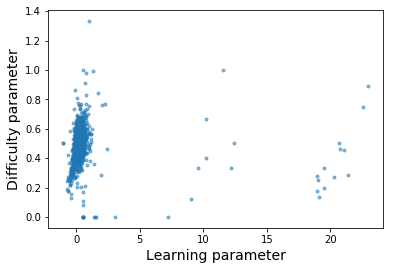

In [9]:
plt.scatter(stud_learning_parameters['Learning parameter'], \
         stud_learning_parameters['Difficulty parameter'], \
            marker='.', \
           alpha=0.5)
plt.xlabel("Learning parameter", size=14)
plt.ylabel("Difficulty parameter", size=14)
plt.show()